In [1]:
# imports
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LogisticRegression as logreg


import TwoPUtils
import STX3KO_analyses as stx



%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def common_rois(roi_matches,inds):
    
    
    ref =  roi_matches[inds[0]]
    ref_common_rois = []
    
    
    for i, targ_ind in enumerate(inds[1:]):
        
#         targ = roi_matches[targ_ind][inds[0]]
        if i==0:
            
            ref_common_rois = set(ref[targ_ind]['ref_inds']) 
        else: 
            ref_common_rois = ref_common_rois & set(ref[targ_ind]['ref_inds'])
        
        # find cells that are in reference match list each time
    ref_common_rois = list(ref_common_rois)

    # find matching indices
    common_roi_mapping = np.zeros([len(inds), len(ref_common_rois)])*np.nan
    common_roi_mapping[0,:]=ref_common_rois
    for i, roi in enumerate(ref_common_rois):
        for j, targ_ind in enumerate(inds[1:]):
#             print(j)
            ind = np.argwhere(ref[targ_ind]['ref_inds']==roi)[0][0]
#             print(j,roi,ind)
            common_roi_mapping[j+1,i] = ref[targ_ind]['targ_inds'][ind]

    return common_roi_mapping.astype(np.int)

def load_single_day(mouse, day = 0):

#     mouse = '4467331.2'
    pkldir = os.path.join('/home/mplitt/YMazeSessPkls/',mouse)
    if mouse in stx.ymaze_sess_deets.KO_sessions.keys():
        
        deets = stx.ymaze_sess_deets.KO_sessions[mouse][day]
    elif mouse in stx.ymaze_sess_deets.CTRL_sessions.keys():
        deets = stx.ymaze_sess_deets.CTRL_sessions[mouse][day]
    else:
        raise Exception("invalid mouse name")


    print(deets)
    if isinstance(deets,tuple):
        with open(os.path.join(pkldir,"roi_aligner_results.pkl"),'rb') as file:
            match_inds = dill.load(file)
        
        
        common_roi_mapping = common_rois(match_inds, [d['ravel_ind'] for d in deets])
        sess_list = []
        for _deets in deets:
            _sess = stx.session.YMazeSession.from_file(
                                os.path.join(pkldir, _deets['date'], "%s_%d.pkl" % (_deets['scene'], _deets['session'])),
                                verbose=False)
            _sess.add_timeseries(licks=_sess.vr_data['lick']._values)
            _sess.add_pos_binned_trial_matrix('licks')
            _sess.novel_arm = _deets['novel']
    #             _sess_list.append(sess)
            print(_deets['date'],_deets['scene'])
            sess_list.append(_sess)


        sess = Concat_Session(sess_list,common_roi_mapping, day_inds = [0 for i in range(len(deets))], trial_mat_keys= ['F_dff', 'spks', 'F_dff_norm', 'spks_norm'])
        if mouse in ['4467332.2'] and day ==0:
            mask = sess.trial_info['sess_num_ravel']>0
            sess.trial_info['block_number'][mask] -= 1
    else:
        sess = stx.session.YMazeSession.from_file(
                                os.path.join(pkldir, deets['date'], "%s_%d.pkl" % (deets['scene'], deets['session'])),
                                verbose=False)
        sess.add_timeseries(licks=sess.vr_data['lick']._values)
        sess.add_pos_binned_trial_matrix('licks')
        sess.novel_arm = deets['novel']
    return sess

class Concat_Session():
    
    def __init__(self,sess_list, common_roi_mapping, trial_info_keys = ['LR', 'block_number'], trial_mat_keys = ['F_dff'], 
                 timeseries_keys = [], run_place_cells = True, day_inds = None):
        attrs = self.concat(sess_list, common_roi_mapping, trial_info_keys, trial_mat_keys, 
                 timeseries_keys, run_place_cells,  day_inds)
        
        self.__dict__.update(attrs)
        trial_info_keys = []
    @staticmethod    
    def concat(_sess_list, common_roi_mapping, t_info_keys, t_mat_keys, 
                 timeseries_keys, run_place_cells,  day_inds):
        attrs = {}
        # same info
#         same_attrs = ['mouse', 'novel_arm','rzone_early', 'rzone_late']
        attrs.update({ 'mouse': _sess_list[0].mouse,
                      'novel_arm': _sess_list[0].novel_arm,
                      'rzone_early': _sess_list[0].rzone_early,
                      'rzone_late': _sess_list[0].rzone_late
                    })
        print(t_info_keys)
        
        # concat basic info 
        basic_info_attrs = ['date', 'scan', 'scan_info', 'scene', 'session', 'teleport_inds', 'trial_start_inds']
        attrs.update({k:[] for k in basic_info_attrs})

        if 'sess_num_ravel' not in t_info_keys:
            t_info_keys.append('sess_num_ravel')
        if 'sess_num' not in t_info_keys and day_inds is not None:
            t_info_keys.append('sess_num')
            
        trial_info = {k:[] for k in t_info_keys}

        trial_mat = {k:[] for k in t_mat_keys}
        trial_mat['bin_edges']=_sess_list[0].trial_matrices['bin_edges']
        trial_mat['bin_centers']=_sess_list[0].trial_matrices['bin_centers']

        timeseries = {k:[] for k in timeseries_keys}

        if run_place_cells:
            place_cells = {-1:{'masks':[], 'SI': [], 'p':[]}, 1: {'masks':[], 'SI': [], 'p':[]}}

        last_block = 0
        for ind, _sess in enumerate(_sess_list):

            for k in basic_info_attrs:
                attrs[k].append(getattr(_sess,k))

            for k in t_info_keys:

                if k == 'sess_num_ravel' :
                    trial_info[k].append(np.zeros([_sess.trial_info['LR'].shape[0],])+ind)
                elif k == 'sess_num' and day_inds is not None:
                    trial_info[k].append(np.zeros([_sess.trial_info['LR'].shape[0],])+day_inds[ind])
            
                elif k == 'block_number' and day_inds is not None and ind>0:
                    if _sess.trial_info[k][0]==0 and day_inds[ind-1]==day_inds[ind]:
                        trial_info[k].append(_sess.trial_info[k] + _sess_list[ind-1].trial_info[k][-1] +1)
                    else:
                        trial_info[k].append(_sess.trial_info[k])
                else:
                    trial_info[k].append(_sess.trial_info[k])

            for k in t_mat_keys:
                trial_mat[k].append(_sess.trial_matrices[k][:,:,common_roi_mapping[ind,:]])

            for k in timeseries_keys:
                timeseries[k].append(_sess.timeseries[k][:,:,common_roi_mapping[ind,:]])


            if run_place_cells:
                for lr, _lr in [[-1,'left'], [1, 'right']]:
                    for k in ['masks', 'SI', 'p']:
                        place_cells[lr][k].append(_sess.place_cell_info[_lr][k][common_roi_mapping[ind,:]])

        print(t_info_keys)
        for k in t_info_keys:
            print(k)
            trial_info[k]= np.concatenate(trial_info[k])
        attrs['trial_info']=trial_info

        for k in t_mat_keys:
            trial_mat[k] = np.concatenate(trial_mat[k],axis=0)
        attrs['trial_matrices']=trial_mat
        
        if run_place_cells:
            for lr in [-1, 1]:
                    for k in ['masks', 'SI', 'p']:
                        place_cells[lr][k] = np.array(place_cells[lr][k])
        attrs['place_cell_info'] = place_cells
        
        return attrs
        

$$P(X \vec Y) \propto P(\vec Y | X) P(X)  = P(X) \prod_{i=0}^{M} P(Y_i| X) \\
P(Y_i|X) \sim Gamma(Y_i; k_{i,x}) \\
Gamma(y; k) = \frac{1}{\Gamma(k)} y^{k-1} e ^{-x} $$

$k$ is the mean dF/F at that position
assume 

In [3]:
mouse = '4467975.2'
sess = load_single_day(mouse,day=0)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}


In [4]:
sess.trial_matrices.keys()

dict_keys(['spks', 'bin_edges', 'bin_centers', 'F_dff_norm', 'spks_norm', 'F_dff', 'licks'])

In [5]:
trial_mat = sess.trial_matrices['F_dff']
trial_mat_mean = np.nanmean(sess.trial_matrices['F_dff'], axis=0)*10
trial_mat_mean = sp.ndimage.filters.gaussian_filter1d(trial_mat_mean,1,axis=0)
print(trial_mat_mean.shape)
print(trial_mat_mean)

# gamma = lambda y,kappa:  1/sp.special.gamma(kappa)* np.exp(-y)*np.power(kappa,y)
gamma = lambda y,kappa:  1/sp.special.gamma(kappa)* np.exp(-kappa)*np.power(kappa,y)

(30, 332)
[[3.12318846 0.29132051 1.82992214 ... 0.62886031 0.40729233 0.54909279]
 [2.94731535 0.26694509 2.11853855 ... 0.56431167 0.41412232 0.55519003]
 [2.64694218 0.23505768 2.59939107 ... 0.47740119 0.42773653 0.55606925]
 ...
 [0.99555629 0.42579086 0.92508635 ... 0.55685    0.32573443 0.44955747]
 [1.16379384 0.40119053 1.11768499 ... 0.70330522 0.33320556 0.4653957 ]
 [1.25073844 0.38495001 1.22813056 ... 0.80726405 0.34763564 0.48632553]]


In [6]:
.05**.05

0.8608916593317348

(60, 30, 30)
(30, 30)


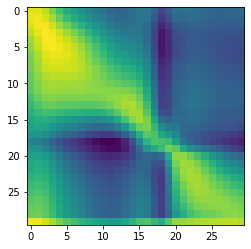

In [7]:
ll = []
for trial in range(60):
    y = trial_mat[trial,:,:]
    y[np.isnan(y)]=1E-3
    y*=10
#     print(y.shape)
    
    _log_likelihood = 0
    for cell in range(y.shape[-1]):
#         print(y[:,cell:cell+1].shape)
        _log_likelihood += np.log(gamma(y[:,cell:cell+1], trial_mat_mean[:,cell:cell+1].T))
    
#     fig,ax = plt.subplots()
#     ax.imshow()
    
    ll.append(_log_likelihood)
print(np.array(ll).shape)
fig,ax = plt.subplots()
print(_log_likelihood.shape)
ax.imshow(np.array(ll).sum(axis=0))
    

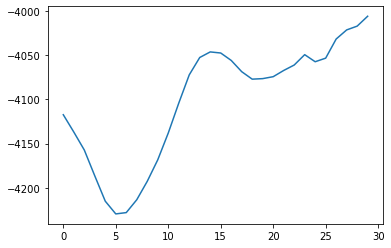

In [17]:
fig,ax = plt.subplots()
ax.plot(ll[0,:])